# Problema 9.4

Seleccionar la ganancia y tiempo integral de un controlador PI, empleando el criterio de hacer mínima la ISE. Considerar un cambio en escalón unidad para la consigna. El proceso a controlar es de primer orden con ganancia 10 y constante de tiempo 1.0. Asumir que las funciones de transferencia del medidor y del elemento final de control son iguales a la unidad. Los parámetros seleccionades deben cumplir las siguientes restricciones:

$$\begin{cases}
    100 \ge K_c \ge 1\\
    10 > \tau_I > 0.1
\end{cases}$$

---

**Solución**



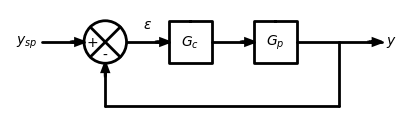

In [1]:
using PyCall, LaTeXStrings

schemdraw = pyimport("schemdraw")
dsp = pyimport("schemdraw.dsp")

d = schemdraw.Drawing(unit=1, fontsize=10)

d.add(dsp.Arrow().right().label(L"y_{sp}", "left"))
comp = d.add(dsp.Mixer(W="+", S="-").anchor("W"))
d.add(dsp.Arrow().right().at(comp.E).label(L"\varepsilon"))
control = d.add(dsp.Box(h=1, w=1).label(L"G_c").anchor("W"))
d.add(dsp.Arrow().right().at(control.E))
proc = d.add(dsp.Box(h=1, w=1).label(L"G_p").anchor("W"))
d.add(dsp.Line().right().at(proc.E))
dot = d.add(dsp.Dot(radius=0))
d.push()
d.add(dsp.Arrow().right().label(L"y", "right"))
d.pop()
d.add(dsp.Line().down().length(1.5))
d.add(dsp.Line().left().tox(comp.S))
d.add(dsp.Arrow().up().to(comp.S))

d.draw(show=false)

Para minimizar la integral del error al cuadrado simularemos el proceso y evaluaremos numéricamente el valor de la integral. Utilizaremos un algortimos de optimización para encontrar la sintonía óptima.

En primer lugar cargaremos las bibliotecas necesarias. Son las siguientes:

- `SymPy.jl`: Para cálculo simbólico, la utilizaremos para realizar los cálculos previos con las funciones de transferenica.

- `Plots.jl`: Para la representación de gráficos.

- `InverseLaplace.jl`: Para evaluar numéricamente las transformadas inversas de Laplace, la utilizaremos para realizar las simulaciones del lazo de control.

- `Trapz.jl`: Para calcular numéricamente la integral utilizando el método de los trapecios.

- `Optim.jl`: Para realizar el proceso de optimización.

In [2]:
using SymPy, InverseLaplace, Plots, Optim, Trapz

Empezaremos definiendo las variables necesarias para poder realizas los cálculos con Sympy:

In [3]:
@vars s

@vars Kc=>"K_c" Ti=>"tau_I" positive=true

@vars t real=true

(t,)

A continuación definimos las funciones de transferencia del proceso y del controlador PI:

In [4]:
Gc = Kc*(1+1/Ti/s)

Gp = 10/(s+1)

  10 
─────
s + 1

En este caso nos interesa conocer como cambia el error $\varepsilon(t)$ en función de un cambio en la consigna $y_{sp}$. Podemos redibujar el lazo de control de la manera siguiente para poner en evidencia que la consigna será la entrada y el error la salidad del bloque equivalente:

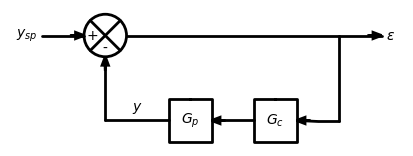

In [5]:
d = schemdraw.Drawing(unit=1, fontsize=10)

d.add(dsp.Arrow().right().label(L"y_{sp}", "left"))
comp = d.add(dsp.Mixer(W="+", S="-").anchor("W"))
d.add(dsp.Line().right().at(comp.E).length(5))
d.push()
dot = d.add(dsp.Dot(radius=0))
d.add(dsp.Arrow().right().label(L"\varepsilon", "right").at(dot.center))
d.pop()
d.add(dsp.Line().down().at(dot.center).length(2))
d.add(dsp.Arrow().left())
control = d.add(dsp.Box(h=1, w=1).label(L"G_c").anchor("E"))
d.add(dsp.Arrow().left().at(control.W))
proc = d.add(dsp.Box(h=1, w=1).label(L"G_p").anchor("E"))
d.add(dsp.Line().left().at(proc.W).tox(comp.S).label(L"y"))
d.add(dsp.Arrow().up().to(comp.S))

d.draw(show=false)

Se trata del mismo lazo de control, lo único que hemos hecho ha sido redibujarlo para indicar con mayor claridad la entrada y la salida que formarán el bloque equivalente:

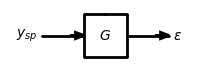

In [6]:
d = schemdraw.Drawing(unit=1, fontsize=10)

d.add(dsp.Arrow().right().label(L"y_{sp}", "left"))
G = d.add(dsp.Box(h=1, w=1).label(L"G").anchor("W"))
d.add(dsp.Arrow().right().label(L"\varepsilon", "right").at(G.E))

d.draw(show=false)

La función de transferencia del bloque equivalente será:

In [7]:
G = 1/(1+Gc*Gp)

          1           
──────────────────────
       ⎛      1  ⎞    
10⋅K_c⋅⎜1 + ─────⎟    
       ⎝    s⋅τ_I⎠    
────────────────── + 1
      s + 1           

La transformada de Laplace del error para un cambio en la consigna en forma de escalón unidad es:

In [8]:
e_s = G*1/s

            1             
──────────────────────────
  ⎛       ⎛      1  ⎞    ⎞
  ⎜10⋅K_c⋅⎜1 + ─────⎟    ⎟
  ⎜       ⎝    s⋅τ_I⎠    ⎟
s⋅⎜────────────────── + 1⎟
  ⎝      s + 1           ⎠

El siguiente paso consiste en definir la función que calculará la ISE:

In [9]:
function ise(x)
    # Los parámetros del controlador se expresan como el vector x, que
    # tiene las siguientes compoenentes (Kc, Ti)
    
    # Tiempo de la simulación
    tsim = range(0, 0.5; length=100)
    
    # Cálculo de error(t) al cuadrado
    # 1. Definición de la transformada inversa de Laplace numérica
    error = ILT(lambdify(e_s(Kc=>x[1], Ti=>x[2])))
    # 2. Obtención del error y se eleva al cuadrado
    e2sim = map(error, tsim).^2
    
    # Convertimos los valores NaN en 0.0, para evitar problemas
    # con trapz()
    for i in range(1, length(e2sim), step=1)
        if isnan(e2sim[i])
            e2sim[i] = 0.0
        end
    end
    
    # Cálculo de la integral
    ise = trapz(tsim, e2sim)
end

ise (generic function with 1 method)

Finalmente, solo queda plantear la optimización, para la que se minimizará el valor de ISE considerando los límites de los parámetros del controlador que propone el enunciado del problema. Como valores iniciales se toma $K_{c_0}=2$ y $\tau_{I_0}=9$:

In [10]:
result = optimize(ise, [1.0, 0.1], [100.0, 10.0], [2.0, 9.0])

 * Status: success

 * Candidate solution
    Final objective value:     2.040411e-07

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 4.61e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.61e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.85e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   79  (vs limit Inf)
    Iterations:    5
    f(x) calls:    170
    ∇f(x) calls:   170


Creamos dos nuevas variables con los valores de los parámetros del controlador que minimizan la ISE:

In [11]:
Kc_optim, Ti_optim = Optim.minimizer(result)

2-element Vector{Float64}:
 99.99999999955537
  0.9064682428332298

Finalmente, comprobamos la sintonía del controlador simulando la respuesta del lazo de control para un cambio de la consigna en forma de escalón uniadad:

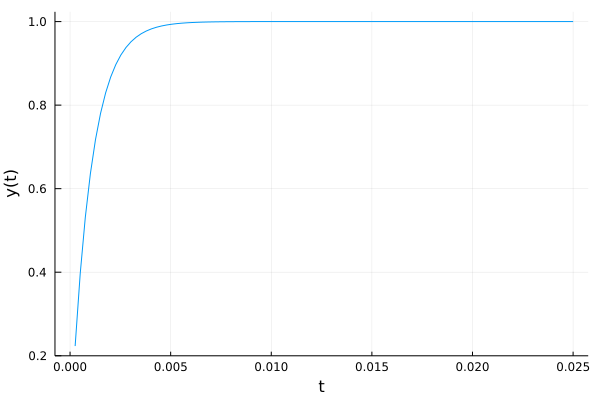

In [13]:
y_s = Gc*Gp/(1+Gc*Gp)*1/s

y_t = ILT(lambdify(y_s(Kc=>Kc_optim, Ti=>Ti_optim)))

tsim = range(0, .025; length=100)


ysim = map(y_t, tsim)

plot(tsim, ysim, legend=false, xlabel="t", ylabel="y(t)")